# How to extract good quality labels using Topic Modeling

# 1)- Importing key modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import nltk; nltk.download('stopwords')
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\69785hsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import nltk
import spacy
import sys
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [4]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [5]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
# plotly
import plotly.graph_objs as go
import plotly.offline as py
from plotly.graph_objs import *
import plotly.figure_factory as ff

py.init_notebook_mode()

In [7]:
# Bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Slider
from bokeh.layouts import column
from bokeh.palettes import all_palettes
output_notebook()

Loading BokehJS ...

In [8]:
# Plotting tools for topic modeling
import pyLDAvis
import pyLDAvis.gensim

# 2)-Loading data

In [9]:
df = pd.read_json('newsgroups.json')
df.head()

content  target  \
0     From: lerxst@wam.umd.edu (where's my thing)\nS...       7   
1     From: guykuo@carson.u.washington.edu (Guy Kuo)...       4   
10    From: irwin@cmptrc.lonestar.org (Irwin Arnstei...       8   
100   From: tchen@magnus.acs.ohio-state.edu (Tsung-K...       6   
1000  From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...       2   

                 target_names  
0                   rec.autos  
1       comp.sys.mac.hardware  
10            rec.motorcycles  
100              misc.forsale  
1000  comp.os.ms-windows.misc

In [10]:
print(df.target_names.unique())

['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']


In [11]:
df.target_names.value_counts()

rec.sport.hockey            600
soc.religion.christian      599
rec.motorcycles             598
rec.sport.baseball          597
sci.crypt                   595
sci.med                     594
rec.autos                   594
comp.windows.x              593
sci.space                   593
sci.electronics             591
comp.os.ms-windows.misc     591
comp.sys.ibm.pc.hardware    590
misc.forsale                585
comp.graphics               584
comp.sys.mac.hardware       578
talk.politics.mideast       564
talk.politics.guns          546
alt.atheism                 480
talk.politics.misc          465
talk.religion.misc          377
Name: target_names, dtype: int64

In [12]:
df.target_names.value_counts().plot(kind='barh')

# 3) Data Preprocessing

### 3.1)-Remove emails and newline characters

In [13]:
df['content'][:5]

0       From: lerxst@wam.umd.edu (where's my thing)\nS...
1       From: guykuo@carson.u.washington.edu (Guy Kuo)...
10      From: irwin@cmptrc.lonestar.org (Irwin Arnstei...
100     From: tchen@magnus.acs.ohio-state.edu (Tsung-K...
1000    From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...
Name: content, dtype: object

In [14]:
#convert to list before cleaning
data = df.content.values.tolist()

In [15]:
data[:1]

["From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"]

In [16]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

<>:3: DeprecationWarning:

invalid escape sequence \S

<>:4: DeprecationWarning:

invalid escape sequence \s

<>:3: DeprecationWarning:

invalid escape sequence \S

<>:4: DeprecationWarning:

invalid escape sequence \s

<>:3: DeprecationWarning:

invalid escape sequence \S

<>:4: DeprecationWarning:

invalid escape sequence \s

<ipython-input-16-d5ee28d0ffa7>:3: DeprecationWarning:

invalid escape sequence \S

<ipython-input-16-d5ee28d0ffa7>:4: DeprecationWarning:

invalid escape sequence \s



[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [17]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

# 4)-Create the Dictionary and Corpus needed for Topic Modeling

In [18]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

In [19]:
id2word[0]

'addition'

In [20]:
print(len(id2word))

69533


In [21]:
count = 0
for k, v in id2word.iteritems():
    print(k, v, id2word.dfs[k])
    count += 1
    if count > 10:
        break

0 addition 219
1 anyone 2089
2 body 377
3 bricklin 4
4 bring 527
5 call 1645
6 car 682
7 could 2297
8 day 1327
9 door 211
10 early 481


In [22]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1)]]


In [23]:
# Human readable format of corpus (term-frequency)
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

[[('addition', 1), ('anyone', 2), ('body', 1), ('bricklin', 1), ('bring', 1), ('call', 1), ('car', 5), ('could', 1), ('day', 1), ('door', 2), ('early', 1), ('engine', 1), ('enlighten', 1), ('front_bumper', 1), ('funky', 1), ('history', 1), ('info', 1), ('know', 1), ('late', 1), ('lerxst', 1), ('line', 1), ('look', 2), ('mail', 1), ('make', 1), ('model', 1), ('name', 1), ('neighborhood', 1), ('organization', 1), ('production', 1), ('really', 1), ('rest', 1), ('see', 1), ('separate', 1), ('small', 1), ('specs', 1), ('sport', 1), ('tellme', 1), ('thank', 1), ('thing', 1), ('umd', 1), ('university', 1), ('wonder', 1), ('year', 1)]]


In [24]:
print(len(corpus))

11314


In [25]:
bow_doc_500 = corpus[500]

for i in range(len(bow_doc_500)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_500[i][0], 
                                                     id2word[bow_doc_500[i][0]], 
                                                     bow_doc_500[i][1]))

Word 20 ("line") appears 1 time.
Word 27 ("organization") appears 1 time.
Word 40 ("university") appears 2 time.
Word 205 ("go") appears 1 time.
Word 221 ("article") appears 3 time.
Word 298 ("write") appears 2 time.
Word 304 ("man") appears 1 time.
Word 444 ("one") appears 1 time.
Word 448 ("present") appears 1 time.
Word 455 ("someone") appears 1 time.
Word 496 ("self") appears 1 time.
Word 499 ("show") appears 5 time.
Word 693 ("general") appears 1 time.
Word 743 ("true") appears 2 time.
Word 796 ("likely") appears 1 time.
Word 980 ("something") appears 2 time.
Word 1162 ("absolute") appears 1 time.
Word 1219 ("concentrate") appears 1 time.
Word 1290 ("hot") appears 3 time.
Word 1395 ("wrong") appears 1 time.
Word 1445 ("correct") appears 1 time.
Word 1643 ("astronomy") appears 2 time.
Word 1715 ("datum") appears 1 time.
Word 1910 ("prove") appears 1 time.
Word 1921 ("usa") appears 1 time.
Word 1995 ("admit") appears 2 time.
Word 2030 ("dept") appears 1 time.
Word 2109 ("respect") a

# 5)-LDA Model

In [26]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [27]:
lda_model.save('lda_model')

In [28]:
from gensim.models import LdaModel
lda_model = LdaModel.load('lda_model')

### 5.1)-shwoing topics

In [29]:
pprint(lda_model.print_topics())

[(0,
  '0.685*"ax" + 0.048*"max" + 0.002*"qax" + 0.001*"qq" + 0.001*"wt" + '
  '0.001*"mf" + 0.001*"air" + 0.001*"mb" + 0.001*"pmfq" + 0.001*"biz"'),
 (1,
  '0.008*"system" + 0.007*"file" + 0.007*"information" + 0.007*"program" + '
  '0.006*"key" + 0.006*"space" + 0.005*"available" + 0.005*"president" + '
  '0.005*"include" + 0.004*"also"'),
 (2,
  '0.010*"say" + 0.010*"would" + 0.009*"people" + 0.008*"write" + 0.007*"know" '
  '+ 0.006*"article" + 0.006*"think" + 0.006*"go" + 0.006*"make" + '
  '0.005*"line"'),
 (3,
  '0.016*"line" + 0.015*"organization" + 0.009*"write" + 0.008*"get" + '
  '0.007*"article" + 0.007*"university" + 0.006*"would" + 0.006*"know" + '
  '0.005*"good" + 0.005*"go"')]


### 5.3)-Dominant topic and its percentage contribution in each document

In [30]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)


In [31]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             3.0              0.8507   
1            1             3.0              0.7063   
2            2             3.0              0.9362   
3            3             1.0              0.5747   
4            4             3.0              0.7738   
5            5             3.0              0.8721   
6            6             3.0              0.9229   
7            7             3.0              0.6405   
8            8             2.0              0.9636   
9            9             2.0              0.9604   

                                            Keywords  \
0  line, organization, write, get, article, unive...   
1  line, organization, write, get, article, unive...   
2  line, organization, write, get, article, unive...   
3  system, file, information, program, key, space...   
4  line, organization, write, get, article, unive...   
5  line, organization, write, get, article, unive...   
6  line, organization, write, get, article, unive...   
7  line, organization, write, get, article, unive...   
8  say, would, people, write, know, article, thin...   
9  say, would, people, write, know, article, thin...   

                                                Text  
0  [thing, car, umd, organization, university, li...  
1  [clock, poll, final, call, summary, final, cal...  
2  [irwin, arnstein, recommendation, duc, summary...  
3  [tsung, kun, chen, software, forsale, lot, org...  
4  [lindbergh, mouse_cursor, organization, nation...  
5  [robert, loper, sc, sun, dseg_ti_com, organiza...  
6  [kim, richard, man, syqu, cartrifge, forsale, ...  
7  [kirtley, wilson, mirosoft, office, package, a...  
8  [innocents_die, death_penalty, organization, l...  
9  [jon_livesey, genocide, cause, atheism, organi...

### 5.4)-most representative sentence for each topic

In [32]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.9998   
1        1.0              0.9469   
2        2.0              0.9944   
3        3.0              0.9978   

                                                                              Keywords  \
0                                         ax, max, qax, qq, wt, mf, air, mb, pmfq, biz   
1  system, file, information, program, key, space, available, president, include, also   
2                      say, would, people, write, know, article, think, go, make, line   
3           line, organization, write, get, article, university, would, know, good, go   

                                                                                   Representative Text  
0  [cliff, reply, organization, university, south_dakota, line, part, wm, exjwz, ax, ax, ax, ax, ax...  
1  [doug_acker, problem, libxmu, suno, gcc, reply, organization, line, se_wg_waii_com, patch, sunos...  
2  [bob_sarver, really, rise, organization, line, emery, single, historic, event, big, impact, worl...  
3  [result, game, play, sit, april, cook_charlie, organization, university, line, philadelphia, fir...

# 6)-Visualization

### 6.1)-Frequency Distribution of Word Counts in Documents

In [33]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning:

object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning:

object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning:

object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning:

object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.



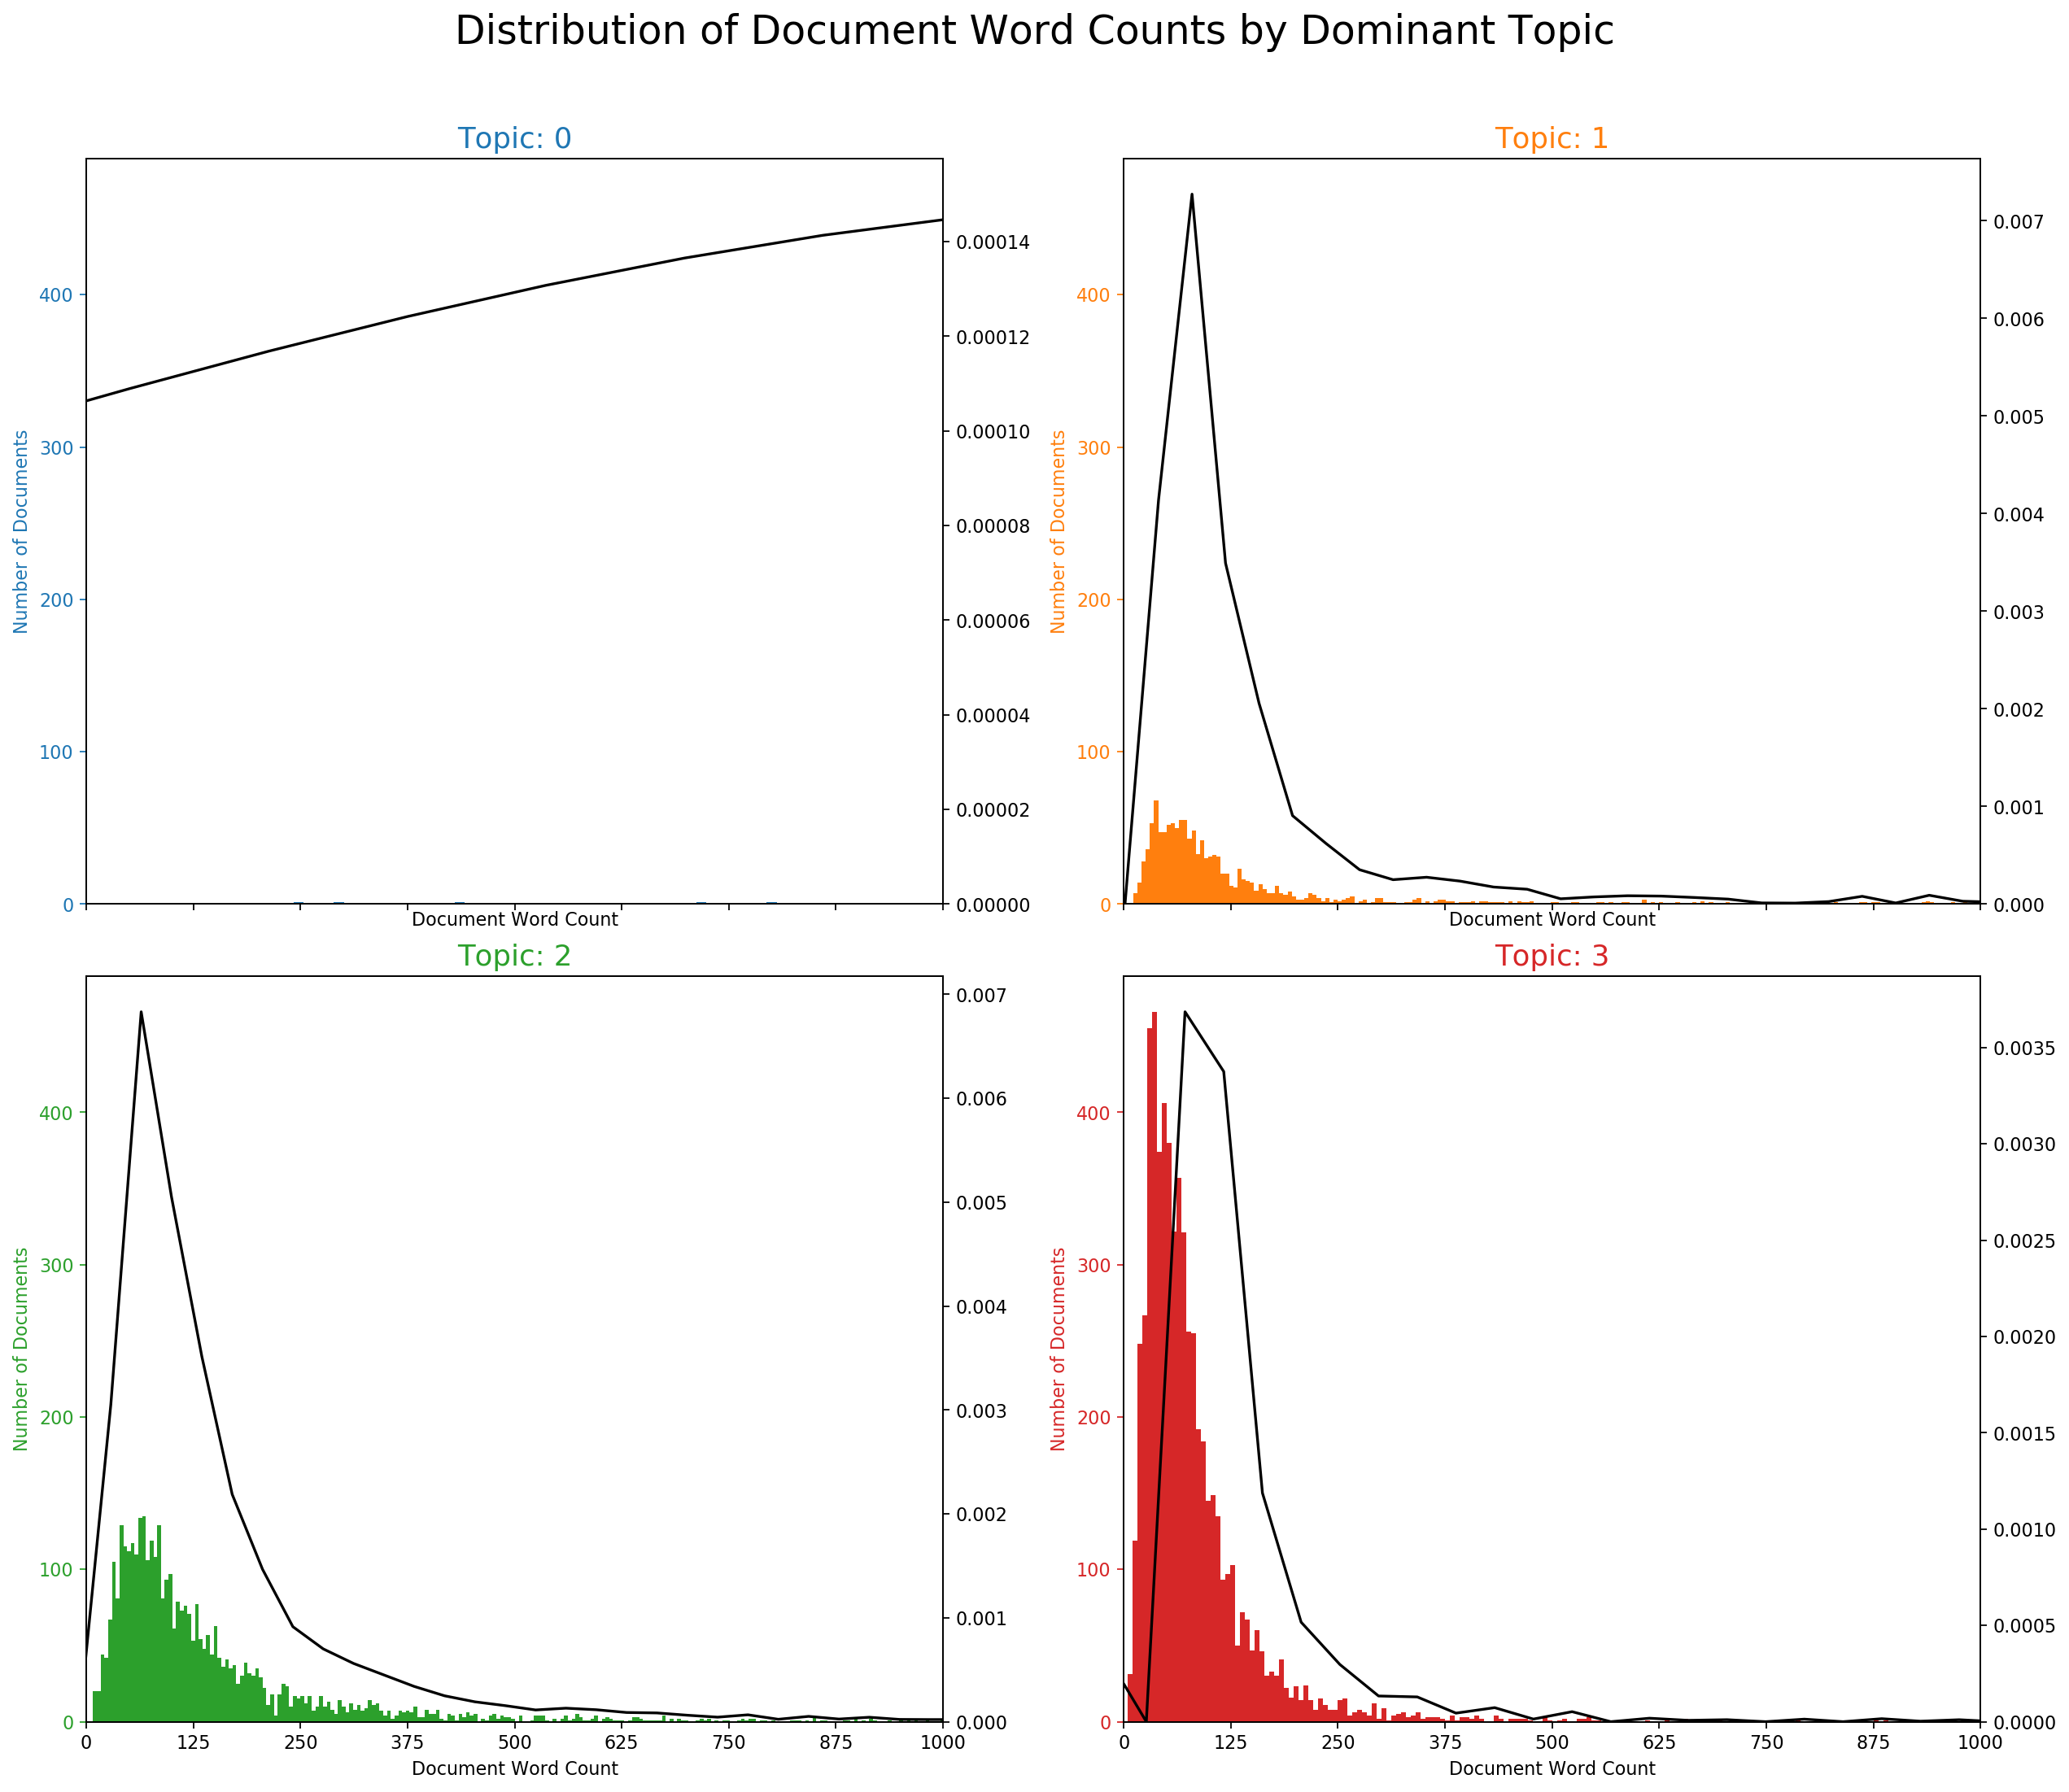

In [34]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### 6.2)-Word Clouds of Top N Keywords in Each Topic

In [35]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### 6.3) bar-plot

In [36]:
fiz=plt.figure(figsize=(15,30))
for i in range(4):
    df=pd.DataFrame(lda_model.show_topic(i), columns=['term','prob']).set_index('term')
    df=df.sort_values('prob')
    
    plt.subplot(5,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df, label='News_topics', palette='Reds_d')
    plt.xlabel('probability')
    

plt.show()

### 6.4)-Word Counts of Topic Keywords

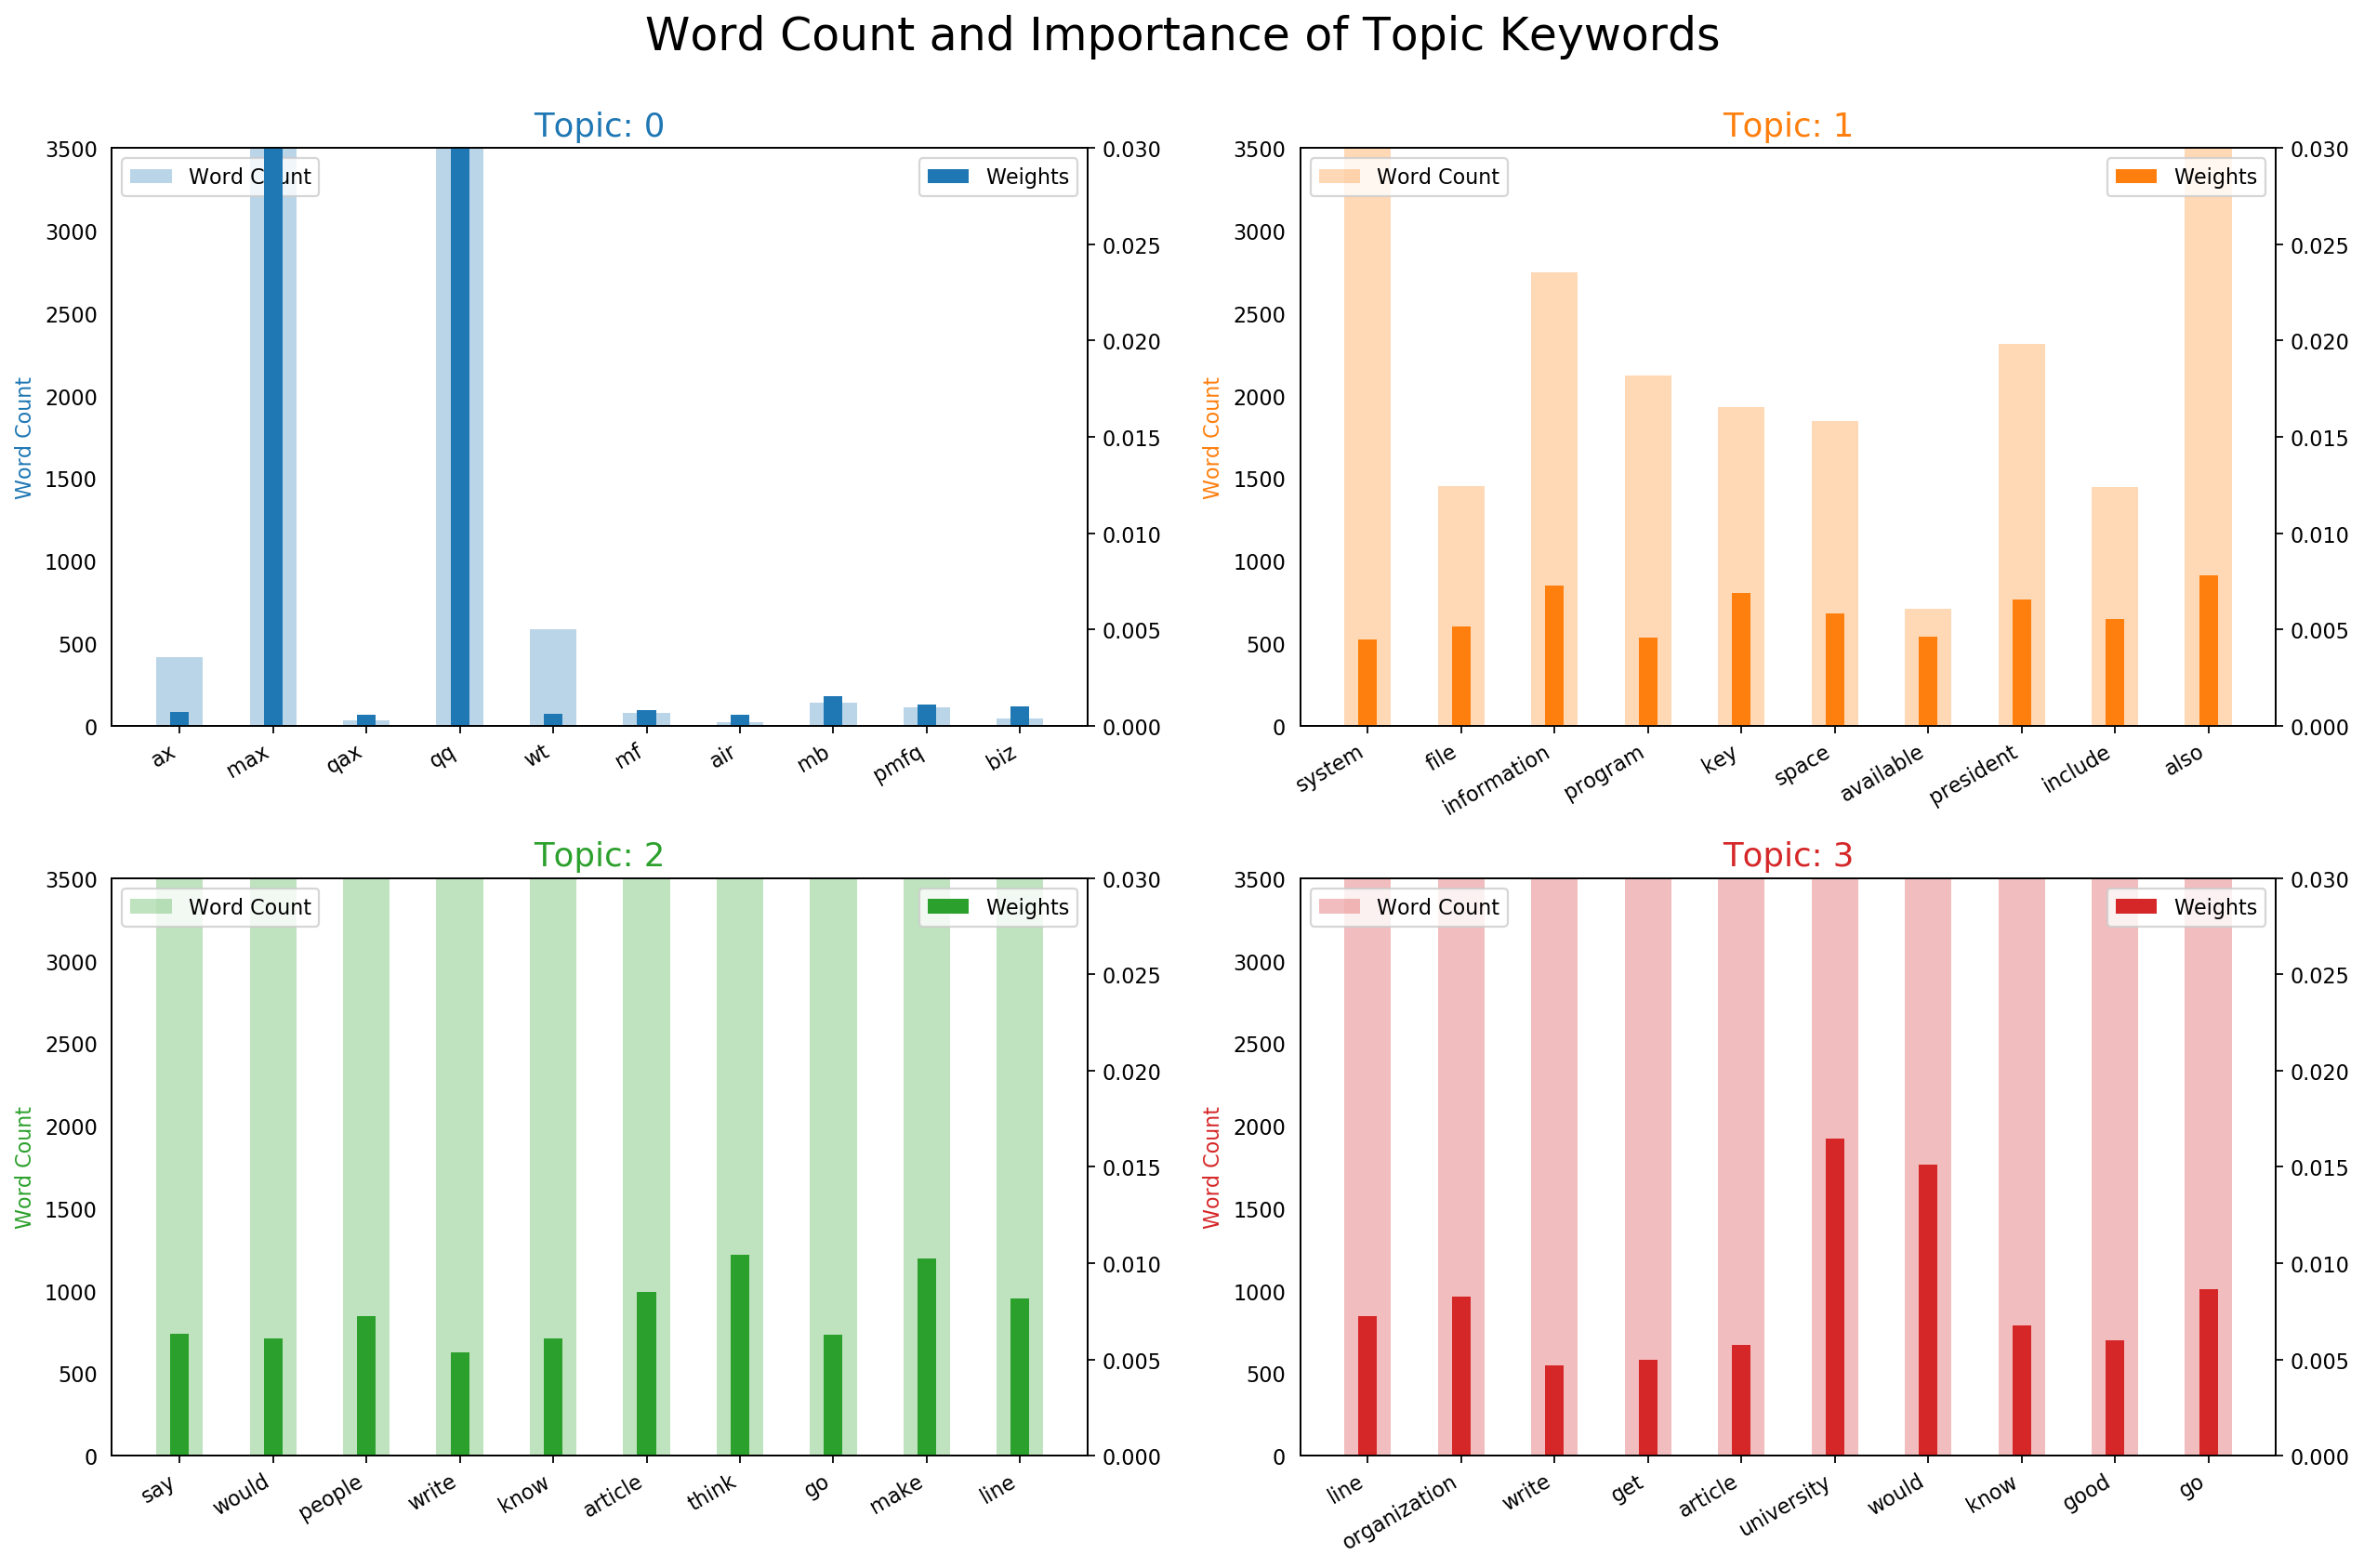

In [37]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### 6.5)-Sentence Chart Colored by Topic

In [38]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

### 6.6)-most discussed topics in the documents

In [39]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

two plots:

The number of documents for each topic by assigning the document to the topic that has the most weight in that document.<br>
The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.

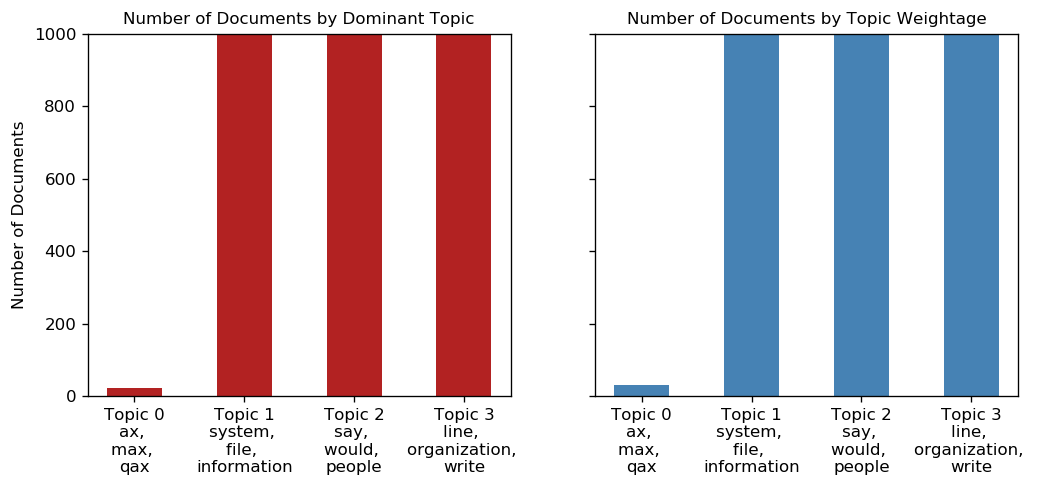

In [40]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

### 6.7)-t-SNE

In [41]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11301 samples in 0.005s...
[t-SNE] Computed neighbors for 11301 samples in 0.200s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11301
[t-SNE] Computed conditional probabilities for sample 2000 / 11301
[t-SNE] Computed conditional probabilities for sample 3000 / 11301
[t-SNE] Computed conditional probabilities for sample 4000 / 11301
[t-SNE] Computed conditional probabilities for sample 5000 / 11301
[t-SNE] Computed conditional probabilities for sample 6000 / 11301
[t-SNE] Computed conditional probabilities for sample 7000 / 11301
[t-SNE] Computed conditional probabilities for sample 8000 / 11301
[t-SNE] Computed conditional probabilities for sample 9000 / 11301
[t-SNE] Computed conditional probabilities for sample 10000 / 11301
[t-SNE] Computed conditional probabilities for sample 11000 / 11301
[t-SNE] Computed conditional probabilities for sample 11301 / 11301
[t-SNE] Mean sigma: 0.006446
[t-SNE] KL divergence

Loading BokehJS ...

### 6.8)-pyLDAvis

In [42]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

C:\Program Files\Anaconda3\lib\site-packages\numexpr\cpuinfo.py:109: DeprecationWarning:

invalid escape sequence \d

C:\Program Files\Anaconda3\lib\site-packages\numexpr\cpuinfo.py:662: DeprecationWarning:

invalid escape sequence \s



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.169401  0.115184       1        1  40.739925
3     -0.151572  0.109908       2        1  34.830330
1     -0.084269 -0.260235       3        1  18.887741
0      0.405242  0.035143       4        1   5.542006, topic_info=      Category          Freq          Term         Total  loglift  logprob
term                                                                      
3930   Default  55928.000000            ax  55928.000000  30.0000  30.0000
3525   Default   3945.000000           max   3945.000000  29.0000  29.0000
380    Default   5197.000000        people   5197.000000  28.0000  28.0000
279    Default   7253.000000           say   7253.000000  27.0000  27.0000
691    Default   2028.000000          file   2028.000000  26.0000  26.0000
27     Default  11171.000000  organization  11171.000000  25.0000  25.0000
340    Default   1818.000000       program   1818.000000  24.0000  24.0000
188    Default   3540.000000        system   3540.000000  23.0000  23.0000
2266   Default   2222.000000   information   2222.000000  22.0000  22.0000
20     Default  12604.000000          line  12604.000000  21.0000  21.0000
707    Default   1619.000000           key   1619.000000  20.0000  20.0000
1792   Default   2110.000000         space   2110.000000  19.0000  19.0000
141    Default   1617.000000     available   1617.000000  18.0000  18.0000
2573   Default   2101.000000          game   2101.000000  17.0000  17.0000
221    Default   7515.000000       article   7515.000000  16.0000  16.0000
899    Default   2410.000000       believe   2410.000000  15.0000  15.0000
197    Default   2023.000000        window   2023.000000  14.0000  14.0000
1056   Default   1287.000000     president   1287.000000  13.0000  13.0000
424    Default   2325.000000           god   2325.000000  12.0000  12.0000
528    Default   1956.000000          team   1956.000000  11.0000  11.0000
37     Default   2271.000000         thank   2271.000000  10.0000  10.0000
1751   Default   1127.000000         image   1127.000000   9.0000   9.0000
52     Default   1819.000000          card   1819.000000   8.0000   8.0000
302    Default   1866.000000       include   1866.000000   7.0000   7.0000
205    Default   6048.000000            go   6048.000000   6.0000   6.0000
132    Default   5468.000000         think   5468.000000   5.0000   5.0000
906    Default   1869.000000     christian   1869.000000   4.0000   4.0000
40     Default   4541.000000    university   4541.000000   3.0000   3.0000
1715   Default   1091.000000         datum   1091.000000   2.0000   2.0000
240    Default   1706.000000         drive   1706.000000   1.0000   1.0000
...        ...           ...           ...           ...      ...      ...
39858   Topic4     25.848597           rmw     26.641552   2.8626  -8.0577
27280   Topic4     25.528215           khf     26.323029   2.8622  -8.0701
26343   Topic4     24.598396           pne     25.389122   2.8612  -8.1073
26352   Topic4     24.342003           qtm     25.132730   2.8608  -8.1177
26260   Topic4     23.358141           giz     24.148867   2.8595  -8.1590
8613    Topic4     22.735256            wm     23.528751   2.8585  -8.1860
26341   Topic4     22.339888           pmf     23.130615   2.8580  -8.2036
26291   Topic4     22.117939           klj     22.908665   2.8577  -8.2135
26231   Topic4     22.058371          eqtm     22.849096   2.8576  -8.2162
8616    Topic4     80.077599            wt     83.014893   2.8568  -6.9269
26333   Topic4     19.944998          nrhj     20.735723   2.8539  -8.3170
26376   Topic4     19.633204           tct     20.423929   2.8533  -8.3327
26334   Topic4     18.501099          nriz     19.291824   2.8510  -8.3921
27872   Topic4     18.311874         bizwt     19.102606   2.8505  -8.4024
27291   Topic4     18.318424           kjz     19.110809   2.8505  -8.4020
8075    Topic4     18.002148     

In [43]:
pyLDAvis.save_html(vis, 'pyLDAvis.html')

### 6.9)-HeatMap

In [44]:
def plot_difference(mdiff, title="", annotation=None):
    """
    Helper function to plot difference between models
    """
    annotation_html = None
    if annotation is not None:
        annotation_html = [["+++ {}<br>--- {}".format(", ".join(int_tokens), ", ".join(diff_tokens))
                            for (int_tokens, diff_tokens) in row]
                           for row in annotation]
        
    data = Heatmap(z=mdiff, colorscale='RdBu', text=annotation_html)
    layout = Layout(width=950, height=950, title=title,
                       xaxis=dict(title="topic"), yaxis=dict(title="topic"))
    py.iplot(dict(data=[data], layout=layout))

In [45]:
difference_matrix, annotation = lda_model.diff(lda_model, distance='jensen_shannon', num_words=50)
plot_difference(difference_matrix, title="Topic difference [jensen shannon distance]", annotation=annotation)

### 6.10-Dendogram

In [46]:
from scipy import spatial as scs
from scipy.cluster import hierarchy as sch
from scipy.spatial.distance import pdist, squareform
from gensim.matutils import jensen_shannon

# get topic distributions
topic_dist = lda_model.state.get_lambda()

# get topic terms
num_words = 300
topic_terms = [{w for (w, _) in lda_model.show_topic(topic, topn=num_words)} for topic in range(topic_dist.shape[0])]

# no. of terms to display in annotation
n_ann_terms = 4

# use Jensen-Shannon distance metric in dendrogram
def js_dist(X):
    return pdist(X, lambda u, v: jensen_shannon(u, v))

# define method for distance calculation in clusters
linkagefun=lambda x: sch.linkage(x, 'single')

# calculate text annotations
def text_annotation(topic_dist, topic_terms, n_ann_terms, linkagefun):
    # get dendrogram hierarchy data
    linkagefun = lambda x: sch.linkage(x, 'single')
    d = js_dist(topic_dist)
    Z = linkagefun(d)
    P = sch.dendrogram(Z, orientation="bottom", no_plot=True)

    # store topic no.(leaves) corresponding to the x-ticks in dendrogram
    x_ticks = np.arange(5, len(P['leaves']) * 10 + 5, 10)
    x_topic = dict(zip(P['leaves'], x_ticks))

    # store {topic no.:topic terms}
    topic_vals = dict()
    for key, val in x_topic.items():
        topic_vals[val] = (topic_terms[key], topic_terms[key])

    text_annotations = []
    # loop through every trace (scatter plot) in dendrogram
    for trace in P['icoord']:
        fst_topic = topic_vals[trace[0]]
        scnd_topic = topic_vals[trace[2]]
        
        # annotation for two ends of current trace
        pos_tokens_t1 = list(fst_topic[0])[:min(len(fst_topic[0]), n_ann_terms)]
        neg_tokens_t1 = list(fst_topic[1])[:min(len(fst_topic[1]), n_ann_terms)]

        pos_tokens_t4 = list(scnd_topic[0])[:min(len(scnd_topic[0]), n_ann_terms)]
        neg_tokens_t4 = list(scnd_topic[1])[:min(len(scnd_topic[1]), n_ann_terms)]

        t1 = "<br>".join((": ".join(("+++", str(pos_tokens_t1))), ": ".join(("---", str(neg_tokens_t1)))))
        t2 = t3 = ()
        t4 = "<br>".join((": ".join(("+++", str(pos_tokens_t4))), ": ".join(("---", str(neg_tokens_t4)))))

        # show topic terms in leaves
        if trace[0] in x_ticks:
            t1 = str(list(topic_vals[trace[0]][0])[:n_ann_terms])
        if trace[2] in x_ticks:
            t4 = str(list(topic_vals[trace[2]][0])[:n_ann_terms])

        text_annotations.append([t1, t2, t3, t4])

        # calculate intersecting/diff for upper level
        intersecting = fst_topic[0] & scnd_topic[0]
        different = fst_topic[0].symmetric_difference(scnd_topic[0])

        center = (trace[0] + trace[2]) / 2
        topic_vals[center] = (intersecting, different)

        # remove trace value after it is annotated
        topic_vals.pop(trace[0], None)
        topic_vals.pop(trace[2], None)  
        
    return text_annotations

# get text annotations
annotation = text_annotation(topic_dist, topic_terms, n_ann_terms, linkagefun)

# Plot dendrogram
dendro = ff.create_dendrogram(topic_dist, distfun=js_dist, labels=range(0, 4), linkagefun=linkagefun, hovertext=annotation)
dendro['layout'].update({'width': 1000, 'height': 600})
py.iplot(dendro)